In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Set this before importing TensorFlow

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from PIL import Image
import pandas as pd
import seaborn as sns

In [2]:
# Test GPUs Working Correctly
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is using the CPU.")

TensorFlow is using the GPU.


## Problem Description and Data

The goal of this project is to build a Convolutional Neural Network that would classify metastatic cancer in small image patches. The dataset used is provided by Kaggle: Histopathologic Cancer Detection: <https://www.kaggle.com/c/histopathologic-cancer-detection/data>

The data downloaded here is split into train and test sets, and it is the test set that will determine the final Kaggle score. The dataset consists of 96 by 96 pixel images with 3 color channels for a total of 27,648 total inputs per image. However, only the center 32 by 32 pixel patch of each image actually determines the classification (according to Kaggle). Each image comes in a .tif format and is named {id}.tif. For the training set, a csv is also provided where the images id is recorded as either 1 (positive for metastatic cancer) or 0 (negative for metastatic cancer). Below is an example of one of these image files. This particular image is negative for metastatic cancer.

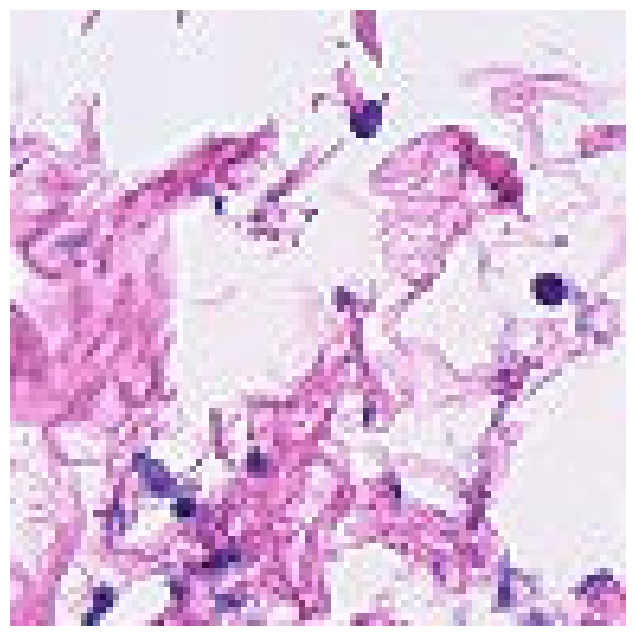

In [3]:
image = Image.open('./data/train/0000d563d5cfafc4e68acb7c9829258a298d9b6a.tif')
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

## EDA 

### Initial Conseriderations: Dataset Preview, Missing Data, Dataset Skew

#### 1. Dataset Preview
Important to take a look at a few samples of both positive and negative labels



In [4]:
#Load training dataset labels:
data_labels = pd.read_csv('./data/train_labels.csv')
data_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


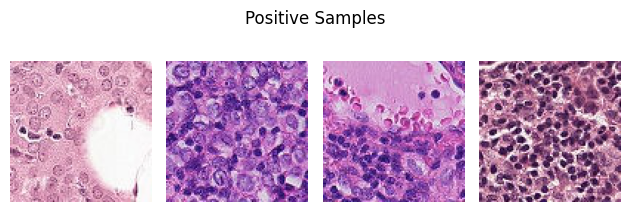

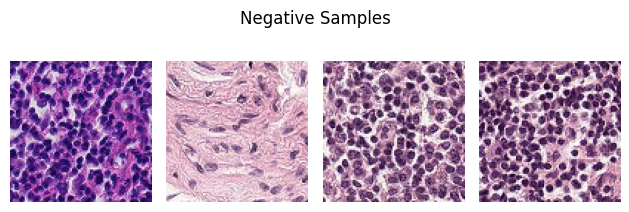

In [5]:
# Printing off some samples of both positive and negative cases
num_samples = 4

positive_samples = data_labels.loc[data_labels['label'] == 1].sample(num_samples)
negative_samples = data_labels.loc[data_labels['label'] == 0].sample(num_samples)

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + positive_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Positive Samples", y=.72)
plt.tight_layout()

fig, axes = plt.subplots(1, num_samples)
for idx, a in enumerate(axes):
    image = Image.open('./data/train/' + negative_samples.iloc[idx]['id'] + '.tif')
    a.imshow(image)
    a.axis('off')
fig.suptitle("Negative Samples", y=.72)
plt.tight_layout()



#### 2. Missing Data
Quick Check on the Images and CSV to ensure that all images have associated labels. 


In [6]:
# Missing Data Check

# First to see if there are any non-labeled ids:
print("Check to see if data labels have any missing data\n", data_labels.isna().sum())
# No missing labels at least in the csv

# Check to see if all labels in the csv have a matching .tif
# Extract all expected file paths from the labels DataFrame
label_ids = data_labels['id'].tolist()
missing_files = []
# Check for each label if the corresponding .tif file exists
for label_id in label_ids:
    image_path = os.path.join('./data/train', f"{label_id}.tif")
    if not os.path.exists(image_path):
        missing_files.append(label_id)

print('Number of missing tif files:', len(missing_files))

Check to see if data labels have any missing data
 id       0
label    0
dtype: int64
Number of missing tif files: 0


#### 3. Dataset Skew
Our training dataset may have a large amount of either positive or negative classifying cases. This skew may need to be addressed to get better model performance.


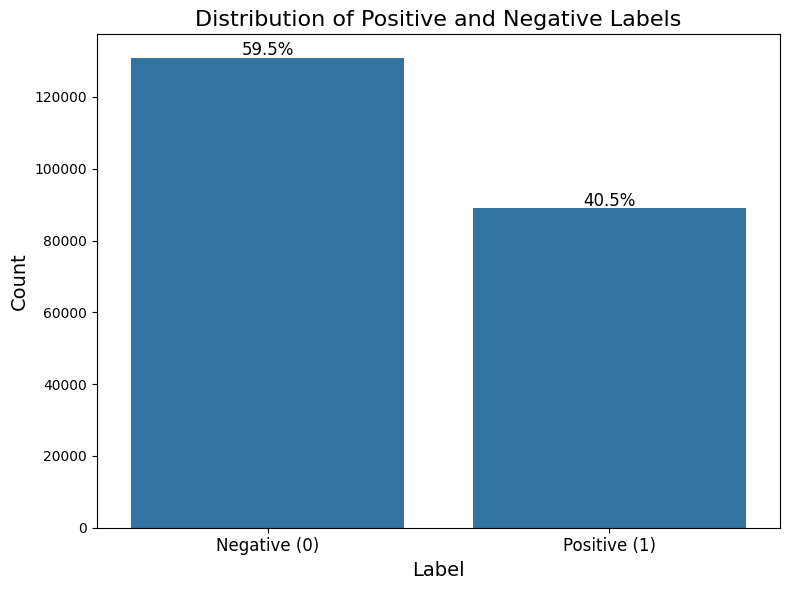

In [7]:
# Extract label counts and percentages
label_counts = data_labels['label'].value_counts()
total_samples = len(data_labels)
percentages = (label_counts / total_samples) * 100


plt.figure(figsize=(8, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)

# Annotate percentages on the bars
for i, (count, percentage) in enumerate(zip(label_counts.values, percentages)):
    plt.text(i, count*1.005, f"{percentage:.1f}%", ha='center', fontsize=12)

plt.title("Distribution of Positive and Negative Labels", fontsize=16)
plt.xlabel("Label", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(ticks=[0, 1], labels=["Negative (0)", "Positive (1)"], fontsize=12)
plt.tight_layout()

plt.show()


## Description of Model
The data provided seems to be of good quality. There is no missing labels, and the dataset skew isn't too bad. Just by looking at the positive and negative samples, I am unable to tell which categories the images belong to. I'll start the investigation process by building a simple CNN model, of type (CNN CNN Maxpool) * n --> Dense Classifier. I'll set n arbitrarily to 3 at the start, and will allow this to be tweaked as I refine the model. 


To start, I will use CNNs layers with 64 filters, then down to 32, and the final CNN layer will have 16. Since early CNN layers pick up the most basic features of a dataset, having plenty of these will hopefully allow the later stages to combine these basic features into more complex ones that will have a better indication on the outcome. 


Afterwards the classifier will be two dense layers of 128 and then 64 nodes, and one output node.

All hidden layers will make use of the ReLu activation function, and the output layer will be a sigmoid activation since this is a classifier type problem.




In [8]:
basic_model = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(8, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=1000,
    decay_rate=0.92,
    staircase=True)

basic_model.summary()
basic_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 44, 44, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 42, 42, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 19, 19, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 17, 8)      │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,817 (362.57 KB)

 Trainable params: 92,817 (362.57 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
# Dataset Maker
# Path to the folder containing the .tif images
image_folder = "data/train"

# Function to load image
def load_image(image_id):
    image_path = os.path.join(image_folder, f"{image_id}.tif")
    image = Image.open(image_path)
    return tf.convert_to_tensor(image, dtype=tf.float32) / 255.0 

# Function to process an ID and label
def process_row(row):
    image = load_image(row['id'])
    label = tf.convert_to_tensor(int(row['label']), dtype=tf.int32)
    return image, label

    # Create a list of tuples (id, label) from the dataframe
data = list(zip(data_labels['id'], data_labels['label']))

# Create a TensorFlow Dataset
def generator():
    for id_, label in data:
        yield load_image(id_), tf.convert_to_tensor(int(label), dtype=tf.int32)

# Create the tf.data.Dataset
dataset = tf.data.Dataset.from_generator(
    generator,
    output_signature=(
        tf.TensorSpec(shape=(96, 96, 3), dtype=tf.float32),  # Adjust channels if grayscale
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )
)

BATCH_SIZE = 32
shuffled_dataset = dataset.shuffle(buffer_size=1000, seed=7) # Shuffle dataset


validation_split = 0.2  # 20% for validation
train_split = 1 - validation_split
dataset_size = len(data_labels)  # Number of samples in the dataset
train_size = int(train_split * dataset_size)
validation_size = dataset_size - train_size

train_dataset = shuffled_dataset.take(train_size)
validation_dataset = shuffled_dataset.skip(train_size)

# Optional: Batch the datasets (if not already batched)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
validation_dataset = validation_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [10]:

basic_hist = basic_model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
5501/5501 ━━━━━━━━━━━━━━━━━━━━ 521s 94ms/step - accuracy: 0.7510 - loss: 0.4976 - val_accuracy: 0.7526 - val_loss: 0.5615
Epoch 2/10


/Users/spasangelov/Desktop/Development/CU Boulder/CSCA 5642/week3/CSCA-5642---CNN-Cancer-Detection-Kaggle/venv/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


5501/5501 ━━━━━━━━━━━━━━━━━━━━ 213s 39ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.7523 - val_loss: 0.5617
Epoch 3/10
 257/5501 ━━━━━━━━━━━━━━━━━━━━ 3:55 45ms/step - accuracy: 0.7898 - loss: 0.4594

KeyboardInterrupt: 

After doing 3 epochs of this basic model, it is clear that the desired accuracy is not being achieved, and further training epochs are resulting in minimal gains. The model is massively underfitting the training data. In order to improve model performance, it is clear that the model complexity will need to be increased. This can be done by adding more layers (going deeper), adding more nuerons in a layer, or changing the architecure. For now, let's add another set of convolutional layers (2 Convolutions, 1 MAX Pool), and check how the model reacts.

In [11]:
basic_model_deeper = tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_deeper.summary()
basic_model_deeper.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 92, 92, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 44, 44, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 42, 42, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 21, 21, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 19, 19, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 6, 6, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,721 (276.25 KB)

 Trainable params: 70,721 (276.25 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
basic_model_deeper_hist = basic_model_deeper.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)


Epoch 1/10
 100/5501 ━━━━━━━━━━━━━━━━━━━━ 5:16 59ms/step - accuracy: 0.4785 - loss: 0.6890

KeyboardInterrupt: 

Even with the Deeper architecture, the resulting gains are not of the order to be expected. This indicates that there is some sort of bottleneck preventing the model from learning the correct the behaviour. This is likely due to the compression of information as information flows from the Convolutional part of the model. Even with almost 4 times the amount of parameters, this model isn't even arguably better. So instead of going deeper, let's go wider.

In [13]:
basic_model_wider= tf.keras.Sequential([
    tf.keras.Input(shape=(96, 96, 3)),
    
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(),


    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')


])


basic_model_wider.summary()
basic_model_wider.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss='binary_crossentropy',
    metrics=['accuracy'] 
)



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 94, 94, 128)    │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 92, 92, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 46, 46, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 44, 44, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 42, 42, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 21, 21, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 19, 19, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 17, 17, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 560,193 (2.14 MB)

 Trainable params: 560,193 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
basic_model_wider_hist = basic_model_wider.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10
)

Epoch 1/10
 173/5501 ━━━━━━━━━━━━━━━━━━━━ 9:38 109ms/step - accuracy: 0.6204 - loss: 0.6500

KeyboardInterrupt: 